In [ ]:
# import libreries
import os
import pandas as pd
from PIL import Image
import numpy as np
from keras.preprocessing.image import img_to_array, load_img

from google.colab import drive

In [ ]:
# set Google Drive path

drive.mount('/content/drive')                   # standard
DATA_DIR = '/content/drive/My Drive/HAM10000/'  # write correct folder/path after /My Drive/

Mounted at /content/drive


In [ ]:
# LITE VERSION TEST
# please, remove the LIMIT on num_rows_to_read to load the whole dataset.

# specify the number of rows to read (adjust as needed)
num_rows_to_read = 30

# load only a subset of the dataset
data = pd.read_csv(os.path.join(DATA_DIR, 'HAM10000_metadata.csv'), nrows=num_rows_to_read)

# add a new column to dataset for complete image path
data['image_path'] = DATA_DIR + 'images/' + data['image_id'] + '.jpg'

# create a dictionary for better readability
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# add two more columns for better readability
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['cell_type_idx'] = pd.Categorical(data['cell_type']).codes

# add image to the dataset
data['image'] = data['image_path'].apply(lambda x: Image.open(x).convert('RGB'))


In [ ]:
# fill null ages with the mean
data['age'].fillna((data['age'].mean()), inplace=True)

In [ ]:
# define a function to load and preprocess images
def preprocess_image(image_path):
    # size
    img = load_img(image_path, target_size=(224, 224))
    # pixel normalization to (0,1) by dividing them by 255
    img = img_to_array(img) / 255.0
    return img

In [ ]:
## -- Start Model -- ##

In [ ]:
from sklearn.model_selection import train_test_split

# split the dataset into training and testing sets
# 20 % testing, 80% training
# fixing a random_state ensures that if the code is run multiple times, the same split between the training and test sets is obtained each time
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# separate the images and labels for training and testing sets
train_images = np.array([preprocess_image(img_path) for img_path in train_data['image_path']])
test_images = np.array([preprocess_image(img_path) for img_path in test_data['image_path']])

train_labels = np.array(train_data['cell_type_idx'])
test_labels = np.array(test_data['cell_type_idx'])


In [ ]:
!pip install vit_keras
!pip install keras-vit
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.4 MB/s eta 0:00:00


In [ ]:
from vit_keras import vit
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import math

# initialize a ViT using a vit_32 architecture
vit_model = vit.vit_b32(
        image_size = 224,         # size of the input images expected by the model
        activation = 'softmax',   # activation function for the output layer (softmax for classification)
        pretrained = True,        # pre-trained weights for the model
        include_top = False,      # not include the top classification layer
        pretrained_top = False,   # pre-trained weights for the top classification layer
        classes = 7               # number of output classes for classification
)



/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


353253686/353253686 [==============================] - 3s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


In [ ]:
model = tf.keras.Sequential([
        vit_model,
        # additional layers
        tf.keras.layers.Flatten(),                                      # flatten the output
        tf.keras.layers.BatchNormalization(),                           # batch normalization
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),   # dense layer with GELU activation
        tf.keras.layers.BatchNormalization(),                           # batch normalization
        tf.keras.layers.Dense(7, 'softmax')                             # final classification with softmax
    ],
    name = 'vision_transformer')

# model.summary()

In [ ]:
# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# adam for adaptive learning rate
# sparse categorical cross-entropy cause multiclass classification problems where each instance can only belong to one class

In [ ]:
# define callbacks

# stops training if the loss on validation does not improve for 3 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# saves (in vit_model.h5) only the model weights that led to an improvement on validation loss
model_checkpoint = ModelCheckpoint('vit_model.h5', save_best_only=True)


In [ ]:
def step_decay(epoch):
    initial_lrate = 0.001       # initial learning rate
    drop = 0.1                  # factor by which the learning rate will be dropped
    epochs_drop = 10            # number of epochs after which the learning rate will be dropped
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

# apply this dynamic learning rate adjustment
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)
callbacks = [early_stopping, model_checkpoint, lr_scheduler]

In [ ]:
history = model.fit(
    train_images, train_labels,                 # training
    validation_data=(test_images, test_labels), # validation
    epochs=20,                                  # no. of epochs
    batch_size=32,                              # batch size
    callbacks=callbacks                         # callbacks for monitoring and adjustments during training
)



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
1/1 [==============================] - 16s 16s/step - loss: 2.1517 - accuracy: 0.1667 - val_loss: 2.4137 - val_accuracy: 0.0000e+00 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/20
1/1 [==============================] - 15s 15s/step - loss: 2.1476 - accuracy: 0.1250 - val_loss: 2.4535 - val_accuracy: 0.0000e+00 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/20
1/1 [==============================] - 15s 15s/step - loss: 2.1779 - accuracy: 0.1250 - val_loss: 2.4511 - val_accuracy: 0.0000e+00 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/20
1/1 [==============================] - 14s 14s/step - loss: 2.1115 - accuracy: 0.0833 - val_loss: 2.4445 - val_accuracy: 0.0000e+00 - lr: 0.0010


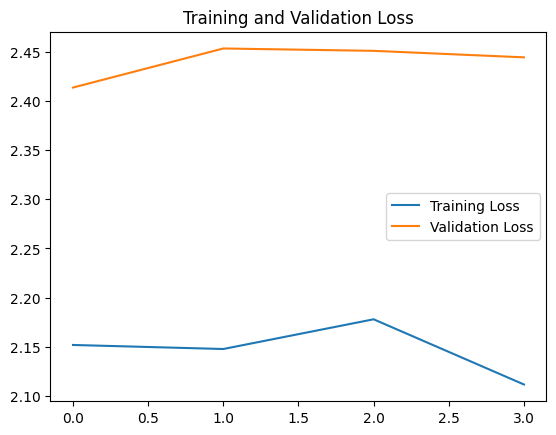

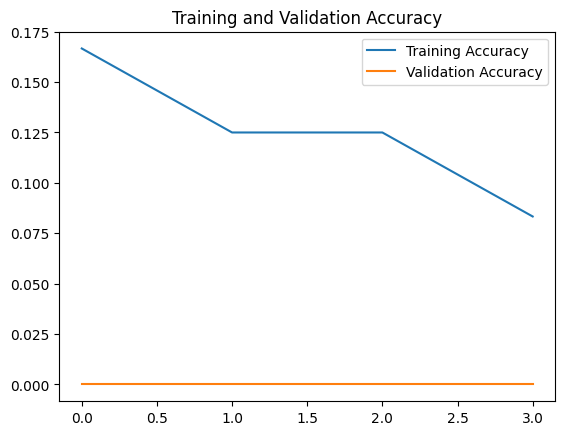

In [ ]:
import matplotlib.pyplot as plt

# plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
# plot the training loss values recorded during each epoch and the validation loss values recorded during each epoch
# OK DEcreasing
# KO large gap = overfitting

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()
# Plot the accuracy of training and validation during each epoch.
# OK INcreasing
# KO large gap = overfitting

# NOTE: Limited dataset - Model test

In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

1/1 [==============================] - 2s 2s/step - loss: 2.4137 - accuracy: 0.0000e+00
Test Loss: 2.4137
Test Accuracy: 0.0000


In [ ]:
predictions = model.predict(test_images)


1/1 [==============================] - 5s 5s/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# create confusion matrix
confusion_mat = confusion_matrix(test_labels, predicted_labels)

# display confusion matrix
print("Confusion Matrix:")
print(confusion_mat)

# classification Report
print("\nClassification Report:")
print(classification_report(test_labels, predicted_labels))


Confusion Matrix:
[[10]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [ ]:
# visualize some predictions
for i in range(5):  # Adjust the range as needed
    print(f"True Label: {test_labels[i]}, Predicted Label: {predicted_labels[i]}")


True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
